In [1]:
# ================================================================
# Imports
# ================================================================
import os
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import random

In [2]:
# ================================================================
# Dataset Definition for H5 frames
# ================================================================
BASE_DIR = "./data/AU"
IMAGE_DIR = os.path.join(BASE_DIR, "image")
META_DIR = os.path.join(BASE_DIR, "metadata")

class TyphoonSequenceDataset(Dataset):
    """
    Creates 10-frame sequences of typhoon .h5 images with constant grade.
    Each sample: (x, y)
        x: Tensor [seq_len, 1, H, W]
        y: intensity grade (0–5)
    """

    def __init__(self, base_dir, seq_len=10, transform=None):
        self.base_dir = base_dir
        self.seq_len = seq_len
        self.transform = transform
        self.image_dir = os.path.join(base_dir, "image")
        self.meta_dir = os.path.join(base_dir, "metadata")
        self.samples = self._prepare_sequences()

    def _list_h5_files(self, typhoon_id):
        dir_path = os.path.join(self.image_dir, typhoon_id)
        files = sorted([
            os.path.join(dir_path, f)
            for f in os.listdir(dir_path)
            if f.lower().endswith(".h5")
        ])
        return files

    def _load_metadata(self, typhoon_id):
        path = os.path.join(self.meta_dir, f"{typhoon_id}.csv")
        if not os.path.exists(path):
            return None
        return pd.read_csv(path)

    def _prepare_sequences(self):
        typhoon_ids = sorted([
            d for d in os.listdir(self.image_dir)
            if os.path.isdir(os.path.join(self.image_dir, d))
        ])

        samples = []
        for typhoon_id in tqdm(typhoon_ids, desc="Building sequences"):
            meta = self._load_metadata(typhoon_id)
            h5_files = self._list_h5_files(typhoon_id)
            if meta is None or "grade" not in meta.columns:
                continue

            grades = meta["grade"].fillna(-1).astype(int).values
            n_frames = min(len(grades), len(h5_files))
            grades = grades[:n_frames]
            h5_files = h5_files[:n_frames]

            start = 0
            while start < n_frames:
                current_grade = grades[start]
                end = start
                while end < n_frames and grades[end] == current_grade:
                    end += 1
                segment_len = end - start
                if current_grade >= 0 and segment_len >= self.seq_len:
                    for i in range(segment_len - self.seq_len + 1):
                        frame_paths = h5_files[start + i:start + i + self.seq_len]
                        samples.append((typhoon_id, frame_paths, current_grade))
                start = end
        return samples

    def __len__(self):
        return len(self.samples)

    def _load_h5_image(self, path):
        with h5py.File(path, "r") as f:
            arr = np.array(f["Infrared"])
        arr = arr.astype(np.float32)
        arr = (arr - arr.min()) / (arr.max() - arr.min() + 1e-8)
        import PIL.Image
        img = PIL.Image.fromarray((arr * 255).astype(np.uint8))
        if self.transform:
            img = self.transform(img)
        else:
            img = transforms.ToTensor()(img)
        return img

    def __getitem__(self, idx):
        _, frame_paths, grade = self.samples[idx]
        imgs = [self._load_h5_image(p) for p in frame_paths]
        x = torch.stack(imgs)  # [seq_len, 1, H, W]
        y = torch.tensor(grade, dtype=torch.long)
        return x, y


# ================================================================
# Create Dataset + Dataloaders
# ================================================================
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

dataset = TyphoonSequenceDataset(BASE_DIR, seq_len=10, transform=transform)
print(f"\nTotal 10-frame constant-grade sequences found: {len(dataset)}")

train_size = int(0.9 * len(dataset))
val_size = int(0.05 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])

train_dl = DataLoader(train_ds, batch_size=8, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=8, shuffle=False)
test_dl = DataLoader(test_ds, batch_size=8, shuffle=False)



Building sequences: 100%|████████████████████| 480/480 [00:00<00:00, 487.74it/s]


Total 10-frame constant-grade sequences found: 50018


In [3]:
# import h5py

# path = "./data/AU/image/201303/2012122613-201303-MTS2-1.h5"

# with h5py.File(path, "r") as f:
#     print("Keys:", list(f.keys()))
#     for k in f.keys():
#         dset = f[k]
#         print(f"  {k}: shape={dset.shape}, dtype={dset.dtype}")

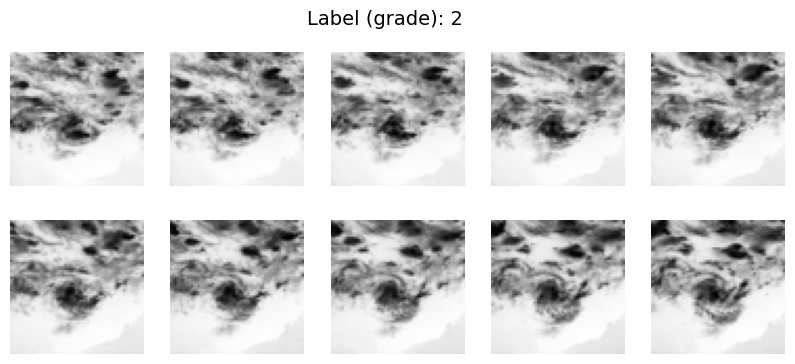

In [4]:
# ================================================================
# Visualize one random sequence
# ================================================================
x, y = random.choice(dataset)
fig, axes = plt.subplots(2, 5, figsize=(10, 4))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(x[i, 0].numpy(), cmap="gray")
    ax.axis("off")
plt.suptitle(f"Label (grade): {y.item()}", fontsize=14)
plt.show()

In [5]:
import torch
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plt

# ================================================================
# ConvLSTM Cell & Classifier
# ================================================================
class ConvLSTMCell(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size, bias=True):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.padding = kernel_size // 2
        self.conv = nn.Conv2d(input_dim + hidden_dim, 4 * hidden_dim,
                              kernel_size, padding=self.padding, bias=bias)

    def forward(self, x, h_prev, c_prev):
        combined = torch.cat([x, h_prev], dim=1)
        conv_out = self.conv(combined)
        cc_i, cc_f, cc_o, cc_g = torch.split(conv_out, self.hidden_dim, dim=1)
        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        o = torch.sigmoid(cc_o)
        g = torch.tanh(cc_g)
        c = f * c_prev + i * g
        h = o * torch.tanh(c)
        return h, c


class ConvLSTMClassifier(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=64, num_classes=6):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(input_dim, 16, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.convlstm = ConvLSTMCell(32, hidden_dim, 3)
        self.fc = nn.Linear(hidden_dim * 16 * 16, num_classes)

    def forward(self, x_seq):
        batch_size, seq_len, _, _, _ = x_seq.shape
        h, c = (torch.zeros(batch_size, 64, 16, 16, device=x_seq.device),
                torch.zeros(batch_size, 64, 16, 16, device=x_seq.device))
        for t in range(seq_len):
            feat = self.encoder(x_seq[:, t])
            h, c = self.convlstm(feat, h, c)
        out = h.view(batch_size, -1)
        return self.fc(out)


# ================================================================
# Training Setup
# ================================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ConvLSTMClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

epochs = 10
val_interval = 200

train_losses, val_losses = [] , []


# ================================================================
# Validation Helper (single-line tqdm)
# ================================================================
@torch.no_grad()
def evaluate_model(model, loader, criterion, device, desc="Validation"):
    model.eval()
    total_loss, correct, total = 0.0, 0, 0
    pbar = tqdm(loader, desc=desc, leave=False, ncols=100, position=0)

    for xb, yb in pbar:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        loss = criterion(preds, yb)
        total_loss += loss.item()
        correct += (preds.argmax(dim=1) == yb).sum().item()
        total += yb.size(0)
        pbar.set_postfix_str(f"batch_loss={loss.item():.4f}")

    avg_loss = total_loss / len(loader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy


# ================================================================
# Training Loop (track avg loss between validation intervals)
# ================================================================
global_step = 0
running_loss = 0.0
steps_since_val = 0
train_interval_losses = []
val_losses = []

for epoch in range(epochs):
    model.train()
    train_iter = tqdm(train_dl, desc=f"Epoch {epoch+1}/{epochs} [Train]", ncols=100)
    
    for xb, yb in train_iter:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()

        # Update running metrics
        running_loss += loss.item()
        steps_since_val += 1
        global_step += 1

        train_iter.set_postfix_str(f"step={global_step}, loss={loss.item():.4f}")

        if global_step % val_interval == 0:
            avg_train_loss = running_loss / steps_since_val
            train_interval_losses.append(avg_train_loss)

            running_loss = 0.0
            steps_since_val = 0

            val_loss, val_acc = evaluate_model(model, val_dl, criterion, device,
                                               desc=f"Step {global_step} [Val]")
            val_losses.append(val_loss)
            tqdm.write(f"[Step {global_step}] Val — Loss: {val_loss:.4f}, Acc: {val_acc:.2f}%")

            model.train()

    if steps_since_val > 0:
        avg_train_loss = running_loss / steps_since_val
        tqdm.write(f"Epoch {epoch+1} — Avg Train Loss (since last val): {avg_train_loss:.4f}")

tqdm.write("✅ Training complete!")

Epoch 1/10 [Train]:   4%|▍             | 200/5627 [04:59<82:47:52, 54.92s/it, step=200, loss=1.0303]

[Step 200] Val — Loss: 1.1888, Acc: 56.96%


Epoch 1/10 [Train]:   7%|▉             | 400/5627 [09:55<78:55:53, 54.36s/it, step=400, loss=1.3240]

[Step 400] Val — Loss: 1.0791, Acc: 59.48%


Epoch 1/10 [Train]:  11%|█▍            | 600/5627 [14:51<75:52:53, 54.34s/it, step=600, loss=0.8579]

[Step 600] Val — Loss: 1.0487, Acc: 60.28%


Epoch 1/10 [Train]:  14%|█▉            | 800/5627 [19:48<73:06:57, 54.53s/it, step=800, loss=0.9427]

[Step 800] Val — Loss: 1.0444, Acc: 60.48%


Epoch 1/10 [Train]:  18%|██▏         | 1000/5627 [24:44<70:10:11, 54.60s/it, step=1000, loss=0.4536]

[Step 1000] Val — Loss: 1.1082, Acc: 59.36%


Epoch 1/10 [Train]:  21%|██▌         | 1200/5627 [29:42<67:25:23, 54.83s/it, step=1200, loss=0.7550]

[Step 1200] Val — Loss: 1.0271, Acc: 60.40%


Epoch 1/10 [Train]:  25%|██▉         | 1400/5627 [34:39<64:02:17, 54.54s/it, step=1400, loss=1.4705]

[Step 1400] Val — Loss: 0.9899, Acc: 62.08%


Epoch 1/10 [Train]:  28%|███▍        | 1600/5627 [39:35<60:56:03, 54.47s/it, step=1600, loss=1.3332]

[Step 1600] Val — Loss: 1.0134, Acc: 61.64%


Epoch 1/10 [Train]:  32%|███▊        | 1800/5627 [44:30<57:52:02, 54.43s/it, step=1800, loss=1.2242]

[Step 1800] Val — Loss: 1.0232, Acc: 59.44%


Epoch 1/10 [Train]:  36%|████▎       | 2000/5627 [49:25<54:55:34, 54.52s/it, step=2000, loss=1.2242]

[Step 2000] Val — Loss: 0.9488, Acc: 62.96%


Epoch 1/10 [Train]:  39%|████▋       | 2200/5627 [54:20<51:41:46, 54.31s/it, step=2200, loss=0.9147]

[Step 2200] Val — Loss: 0.9334, Acc: 63.76%


Epoch 1/10 [Train]:  43%|█████       | 2400/5627 [59:17<49:07:46, 54.81s/it, step=2400, loss=0.7731]

[Step 2400] Val — Loss: 0.9135, Acc: 64.68%


Epoch 1/10 [Train]:  46%|████▌     | 2600/5627 [1:04:13<46:11:57, 54.94s/it, step=2600, loss=1.4437]

[Step 2600] Val — Loss: 0.9421, Acc: 63.08%


Epoch 1/10 [Train]:  50%|████▉     | 2800/5627 [1:09:12<43:11:49, 55.01s/it, step=2800, loss=1.0329]

[Step 2800] Val — Loss: 0.9211, Acc: 64.44%


Epoch 1/10 [Train]:  53%|█████▎    | 3000/5627 [1:14:09<39:49:21, 54.57s/it, step=3000, loss=0.6143]

[Step 3000] Val — Loss: 0.9168, Acc: 64.64%


Epoch 1/10 [Train]:  57%|█████▋    | 3200/5627 [1:19:06<36:50:35, 54.65s/it, step=3200, loss=0.8813]

[Step 3200] Val — Loss: 0.9585, Acc: 63.48%


Epoch 1/10 [Train]:  60%|██████    | 3400/5627 [1:24:02<33:45:35, 54.57s/it, step=3400, loss=0.9128]

[Step 3400] Val — Loss: 0.8922, Acc: 65.56%


Epoch 1/10 [Train]:  64%|██████▍   | 3600/5627 [1:28:59<30:55:28, 54.92s/it, step=3600, loss=0.4316]

[Step 3600] Val — Loss: 0.8750, Acc: 66.28%


Epoch 1/10 [Train]:  68%|██████▊   | 3800/5627 [1:33:53<27:34:10, 54.32s/it, step=3800, loss=1.2582]

[Step 3800] Val — Loss: 0.8676, Acc: 66.12%


Epoch 1/10 [Train]:  71%|███████   | 4000/5627 [1:38:52<24:46:51, 54.83s/it, step=4000, loss=0.4709]

[Step 4000] Val — Loss: 0.8667, Acc: 65.68%


Epoch 1/10 [Train]:  75%|███████▍  | 4200/5627 [1:43:50<21:44:58, 54.87s/it, step=4200, loss=0.5140]

[Step 4200] Val — Loss: 0.8178, Acc: 69.72%


Epoch 1/10 [Train]:  78%|███████▊  | 4400/5627 [1:48:44<18:30:43, 54.31s/it, step=4400, loss=0.7529]

[Step 4400] Val — Loss: 0.7925, Acc: 69.44%


Epoch 1/10 [Train]:  82%|████████▏ | 4600/5627 [1:53:43<15:40:59, 54.97s/it, step=4600, loss=1.4532]

[Step 4600] Val — Loss: 0.8754, Acc: 67.24%


Epoch 1/10 [Train]:  85%|████████▌ | 4800/5627 [1:58:41<12:36:45, 54.90s/it, step=4800, loss=0.6427]

[Step 4800] Val — Loss: 0.8190, Acc: 68.80%


Epoch 1/10 [Train]:  89%|█████████▊ | 5000/5627 [2:03:39<9:34:45, 55.00s/it, step=5000, loss=0.6259]

[Step 5000] Val — Loss: 0.7574, Acc: 71.40%


Epoch 1/10 [Train]:  92%|██████████▏| 5200/5627 [2:08:40<6:33:14, 55.26s/it, step=5200, loss=0.7634]

[Step 5200] Val — Loss: 0.7355, Acc: 72.24%


Epoch 1/10 [Train]:  96%|██████████▌| 5400/5627 [2:13:40<3:28:14, 55.04s/it, step=5400, loss=0.5389]

[Step 5400] Val — Loss: 0.7620, Acc: 70.60%


Epoch 1/10 [Train]: 100%|████████████▉| 5600/5627 [2:18:37<24:33, 54.56s/it, step=5600, loss=1.4643]

[Step 5600] Val — Loss: 0.6976, Acc: 73.60%


Epoch 1/10 [Train]: 100%|█████████████| 5627/5627 [2:18:53<00:00,  1.48s/it, step=5627, loss=0.9783]


Epoch 1 — Avg Train Loss (since last val): 0.5967


Epoch 2/10 [Train]:   3%|▍            | 173/5627 [04:44<83:52:53, 55.37s/it, step=5800, loss=0.3114]

[Step 5800] Val — Loss: 0.6910, Acc: 73.80%


Epoch 2/10 [Train]:   7%|▊            | 373/5627 [09:45<80:52:26, 55.41s/it, step=6000, loss=0.5510]

[Step 6000] Val — Loss: 0.6581, Acc: 75.08%


Epoch 2/10 [Train]:  10%|█▎           | 573/5627 [14:43<77:09:52, 54.96s/it, step=6200, loss=0.1272]

[Step 6200] Val — Loss: 0.6889, Acc: 74.60%


Epoch 2/10 [Train]:  14%|█▊           | 773/5627 [19:40<73:46:56, 54.72s/it, step=6400, loss=0.4446]

[Step 6400] Val — Loss: 0.6380, Acc: 76.76%


Epoch 2/10 [Train]:  17%|██▏          | 973/5627 [24:37<70:48:23, 54.77s/it, step=6600, loss=0.4632]

[Step 6600] Val — Loss: 0.6783, Acc: 74.92%


Epoch 2/10 [Train]:  21%|██▌         | 1173/5627 [29:34<67:33:57, 54.61s/it, step=6800, loss=0.1889]

[Step 6800] Val — Loss: 0.6194, Acc: 77.96%


Epoch 2/10 [Train]:  24%|██▉         | 1373/5627 [34:33<64:39:32, 54.72s/it, step=7000, loss=0.5809]

[Step 7000] Val — Loss: 0.6494, Acc: 76.24%


Epoch 2/10 [Train]:  28%|███▎        | 1573/5627 [39:30<61:57:51, 55.02s/it, step=7200, loss=0.7457]

[Step 7200] Val — Loss: 0.5640, Acc: 79.60%


Epoch 2/10 [Train]:  32%|███▊        | 1773/5627 [44:28<58:44:23, 54.87s/it, step=7400, loss=0.1482]

[Step 7400] Val — Loss: 0.5408, Acc: 80.20%


Epoch 2/10 [Train]:  35%|████▏       | 1973/5627 [49:27<55:39:14, 54.83s/it, step=7600, loss=0.5904]

[Step 7600] Val — Loss: 0.5374, Acc: 80.52%


Epoch 2/10 [Train]:  39%|████▋       | 2173/5627 [54:25<52:54:05, 55.14s/it, step=7800, loss=0.4258]

[Step 7800] Val — Loss: 0.5017, Acc: 81.76%


Epoch 2/10 [Train]:  42%|█████       | 2373/5627 [59:22<49:19:40, 54.57s/it, step=8000, loss=0.1364]

[Step 8000] Val — Loss: 0.4715, Acc: 82.88%


Epoch 2/10 [Train]:  46%|████▌     | 2573/5627 [1:04:22<46:45:12, 55.11s/it, step=8200, loss=0.5359]

[Step 8200] Val — Loss: 0.4735, Acc: 83.24%


Epoch 2/10 [Train]:  49%|████▉     | 2773/5627 [1:09:21<43:40:11, 55.08s/it, step=8400, loss=0.5066]

[Step 8400] Val — Loss: 0.4655, Acc: 83.28%


Epoch 2/10 [Train]:  53%|█████▎    | 2973/5627 [1:14:18<40:08:48, 54.46s/it, step=8600, loss=0.5207]

[Step 8600] Val — Loss: 0.4380, Acc: 83.56%


Epoch 2/10 [Train]:  56%|█████▋    | 3173/5627 [1:19:17<37:31:05, 55.04s/it, step=8800, loss=0.3066]

[Step 8800] Val — Loss: 0.4372, Acc: 84.16%


Epoch 2/10 [Train]:  60%|█████▉    | 3373/5627 [1:24:17<34:30:04, 55.10s/it, step=9000, loss=0.1898]

[Step 9000] Val — Loss: 0.3901, Acc: 86.64%


Epoch 2/10 [Train]:  63%|██████▎   | 3573/5627 [1:29:13<31:10:30, 54.64s/it, step=9200, loss=0.0720]

[Step 9200] Val — Loss: 0.3841, Acc: 86.48%


Epoch 2/10 [Train]:  67%|██████▋   | 3773/5627 [1:34:13<28:19:18, 54.99s/it, step=9400, loss=0.1153]

[Step 9400] Val — Loss: 0.3581, Acc: 87.72%


Epoch 2/10 [Train]:  71%|███████   | 3973/5627 [1:39:12<25:24:30, 55.30s/it, step=9600, loss=0.3094]

[Step 9600] Val — Loss: 0.3406, Acc: 88.76%


Epoch 2/10 [Train]:  74%|███████▍  | 4173/5627 [1:44:10<22:09:24, 54.86s/it, step=9800, loss=0.1012]

[Step 9800] Val — Loss: 0.3605, Acc: 87.60%


Epoch 2/10 [Train]:  78%|██████▉  | 4373/5627 [1:49:08<19:05:56, 54.83s/it, step=10000, loss=0.2870]

[Step 10000] Val — Loss: 0.3469, Acc: 88.28%


Epoch 2/10 [Train]:  81%|███████▎ | 4573/5627 [1:54:08<16:10:46, 55.26s/it, step=10200, loss=0.2316]

[Step 10200] Val — Loss: 0.3171, Acc: 89.32%


Epoch 2/10 [Train]:  85%|███████▋ | 4773/5627 [1:59:06<13:00:00, 54.80s/it, step=10400, loss=0.2564]

[Step 10400] Val — Loss: 0.3413, Acc: 87.28%


Epoch 2/10 [Train]:  88%|████████▊ | 4973/5627 [2:04:04<9:59:58, 55.04s/it, step=10600, loss=0.5228]

[Step 10600] Val — Loss: 0.3001, Acc: 89.76%


Epoch 2/10 [Train]:  92%|█████████▏| 5173/5627 [2:09:03<6:56:47, 55.08s/it, step=10800, loss=0.2072]

[Step 10800] Val — Loss: 0.2937, Acc: 90.08%


Epoch 2/10 [Train]:  95%|█████████▌| 5373/5627 [2:14:04<3:54:33, 55.41s/it, step=11000, loss=0.0460]

[Step 11000] Val — Loss: 0.2502, Acc: 92.12%


Epoch 2/10 [Train]:  99%|███████████▉| 5573/5627 [2:19:04<49:44, 55.28s/it, step=11200, loss=0.4308]

[Step 11200] Val — Loss: 0.2563, Acc: 91.40%


Epoch 2/10 [Train]: 100%|████████████| 5627/5627 [2:19:36<00:00,  1.49s/it, step=11254, loss=0.4242]


Epoch 2 — Avg Train Loss (since last val): 0.2055


Epoch 3/10 [Train]:   3%|▎           | 146/5627 [04:30<84:32:08, 55.52s/it, step=11400, loss=0.6771]

[Step 11400] Val — Loss: 0.2456, Acc: 91.56%


Epoch 3/10 [Train]:   6%|▋           | 346/5627 [09:30<81:15:43, 55.40s/it, step=11600, loss=0.0359]

[Step 11600] Val — Loss: 0.2410, Acc: 91.76%


Epoch 3/10 [Train]:  10%|█▏          | 546/5627 [14:31<78:02:51, 55.30s/it, step=11800, loss=0.2442]

[Step 11800] Val — Loss: 0.2664, Acc: 91.44%


Epoch 3/10 [Train]:  13%|█▌          | 746/5627 [19:30<74:44:45, 55.13s/it, step=12000, loss=0.0322]

[Step 12000] Val — Loss: 0.2463, Acc: 91.72%


Epoch 3/10 [Train]:  17%|██          | 946/5627 [24:31<72:22:48, 55.67s/it, step=12200, loss=0.0436]

[Step 12200] Val — Loss: 0.2421, Acc: 91.76%


Epoch 3/10 [Train]:  20%|██▏        | 1146/5627 [29:32<69:10:26, 55.57s/it, step=12400, loss=0.0601]

[Step 12400] Val — Loss: 0.2206, Acc: 92.80%


Epoch 3/10 [Train]:  24%|██▋        | 1346/5627 [34:33<65:48:23, 55.34s/it, step=12600, loss=0.3861]

[Step 12600] Val — Loss: 0.2265, Acc: 93.00%


Epoch 3/10 [Train]:  27%|███        | 1546/5627 [39:33<62:49:01, 55.41s/it, step=12800, loss=0.1167]

[Step 12800] Val — Loss: 0.2830, Acc: 90.92%


Epoch 3/10 [Train]:  31%|███▍       | 1746/5627 [44:33<59:41:45, 55.37s/it, step=13000, loss=0.0324]

[Step 13000] Val — Loss: 0.2504, Acc: 91.68%


Epoch 3/10 [Train]:  35%|███▊       | 1946/5627 [49:34<56:50:22, 55.59s/it, step=13200, loss=0.0989]

[Step 13200] Val — Loss: 0.1926, Acc: 94.36%


Epoch 3/10 [Train]:  38%|████▏      | 2146/5627 [54:37<53:44:59, 55.59s/it, step=13400, loss=0.0261]

[Step 13400] Val — Loss: 0.1750, Acc: 94.76%


Epoch 3/10 [Train]:  42%|████▌      | 2346/5627 [59:39<50:35:33, 55.51s/it, step=13600, loss=0.8245]

[Step 13600] Val — Loss: 0.1954, Acc: 94.08%


Epoch 3/10 [Train]:  45%|████     | 2546/5627 [1:04:40<47:30:14, 55.51s/it, step=13800, loss=0.0238]

[Step 13800] Val — Loss: 0.2109, Acc: 93.64%


Epoch 3/10 [Train]:  49%|████▍    | 2746/5627 [1:09:40<44:07:52, 55.14s/it, step=14000, loss=0.0126]

[Step 14000] Val — Loss: 0.2165, Acc: 92.72%


Epoch 3/10 [Train]:  52%|████▋    | 2946/5627 [1:14:42<41:25:42, 55.63s/it, step=14200, loss=0.0047]

[Step 14200] Val — Loss: 0.1741, Acc: 94.32%


Epoch 3/10 [Train]:  56%|█████    | 3146/5627 [1:19:42<38:11:25, 55.42s/it, step=14400, loss=0.0312]

[Step 14400] Val — Loss: 0.1851, Acc: 93.96%


Epoch 3/10 [Train]:  59%|█████▎   | 3346/5627 [1:24:44<35:02:01, 55.29s/it, step=14600, loss=0.0525]

[Step 14600] Val — Loss: 0.1527, Acc: 95.12%


Epoch 3/10 [Train]:  63%|█████▋   | 3546/5627 [1:29:46<32:06:07, 55.53s/it, step=14800, loss=0.1736]

[Step 14800] Val — Loss: 0.1596, Acc: 94.56%


Epoch 3/10 [Train]:  67%|█████▉   | 3746/5627 [1:34:45<28:50:08, 55.19s/it, step=15000, loss=0.0343]

[Step 15000] Val — Loss: 0.1594, Acc: 94.76%


Epoch 3/10 [Train]:  70%|██████▎  | 3946/5627 [1:39:46<25:43:58, 55.11s/it, step=15200, loss=0.0138]

[Step 15200] Val — Loss: 0.1494, Acc: 95.44%


Epoch 3/10 [Train]:  74%|██████▋  | 4146/5627 [1:44:46<22:48:02, 55.42s/it, step=15400, loss=0.1710]

[Step 15400] Val — Loss: 0.1350, Acc: 95.56%


Epoch 3/10 [Train]:  77%|██████▉  | 4346/5627 [1:49:50<19:51:19, 55.80s/it, step=15600, loss=0.0777]

[Step 15600] Val — Loss: 0.1473, Acc: 95.48%


Epoch 3/10 [Train]:  81%|███████▎ | 4546/5627 [1:54:51<16:38:03, 55.40s/it, step=15800, loss=0.0281]

[Step 15800] Val — Loss: 0.1294, Acc: 95.88%


Epoch 3/10 [Train]:  84%|███████▌ | 4746/5627 [1:59:51<13:33:13, 55.38s/it, step=16000, loss=0.0240]

[Step 16000] Val — Loss: 0.1496, Acc: 95.32%


Epoch 3/10 [Train]:  88%|███████▉ | 4946/5627 [2:04:51<10:27:33, 55.29s/it, step=16200, loss=0.0198]

[Step 16200] Val — Loss: 0.1155, Acc: 96.36%


Epoch 3/10 [Train]:  91%|█████████▏| 5146/5627 [2:09:52<7:24:58, 55.51s/it, step=16400, loss=0.0779]

[Step 16400] Val — Loss: 0.1119, Acc: 96.56%


Epoch 3/10 [Train]:  95%|█████████▌| 5346/5627 [2:14:53<4:19:59, 55.51s/it, step=16600, loss=0.0246]

[Step 16600] Val — Loss: 0.1444, Acc: 95.16%


Epoch 3/10 [Train]:  99%|█████████▊| 5546/5627 [2:19:52<1:14:12, 54.97s/it, step=16800, loss=0.0335]

[Step 16800] Val — Loss: 0.1090, Acc: 96.32%


Epoch 3/10 [Train]: 100%|████████████| 5627/5627 [2:20:40<00:00,  1.50s/it, step=16881, loss=0.0116]


Epoch 3 — Avg Train Loss (since last val): 0.0767


Epoch 4/10 [Train]:   2%|▎           | 119/5627 [04:13<84:57:21, 55.53s/it, step=17000, loss=0.0129]

[Step 17000] Val — Loss: 0.0994, Acc: 96.24%


Epoch 4/10 [Train]:   6%|▋           | 319/5627 [09:12<81:22:11, 55.19s/it, step=17200, loss=0.0493]

[Step 17200] Val — Loss: 0.0905, Acc: 97.08%


Epoch 4/10 [Train]:   9%|█           | 519/5627 [14:14<78:53:55, 55.61s/it, step=17400, loss=0.0981]

[Step 17400] Val — Loss: 0.1048, Acc: 96.56%


Epoch 4/10 [Train]:  13%|█▌          | 719/5627 [19:14<75:28:39, 55.36s/it, step=17600, loss=0.0001]

[Step 17600] Val — Loss: 0.1032, Acc: 96.40%


Epoch 4/10 [Train]:  16%|█▉          | 919/5627 [24:13<72:01:30, 55.07s/it, step=17800, loss=0.0083]

[Step 17800] Val — Loss: 0.1111, Acc: 96.64%


Epoch 4/10 [Train]:  20%|██▏        | 1119/5627 [29:16<69:46:34, 55.72s/it, step=18000, loss=0.1808]

[Step 18000] Val — Loss: 0.0996, Acc: 96.84%


Epoch 4/10 [Train]:  23%|██▌        | 1319/5627 [34:15<66:09:28, 55.29s/it, step=18200, loss=0.6445]

[Step 18200] Val — Loss: 0.1374, Acc: 95.32%


Epoch 4/10 [Train]:  27%|██▉        | 1519/5627 [39:14<62:47:51, 55.03s/it, step=18400, loss=0.0358]

[Step 18400] Val — Loss: 0.1250, Acc: 95.96%


Epoch 4/10 [Train]:  31%|███▎       | 1719/5627 [44:14<60:13:24, 55.48s/it, step=18600, loss=0.1747]

[Step 18600] Val — Loss: 0.1453, Acc: 95.12%


Epoch 4/10 [Train]:  34%|███▊       | 1919/5627 [49:15<56:53:08, 55.23s/it, step=18800, loss=0.0014]

[Step 18800] Val — Loss: 0.1083, Acc: 96.48%


Epoch 4/10 [Train]:  38%|████▏      | 2119/5627 [54:16<53:52:28, 55.29s/it, step=19000, loss=0.1720]

[Step 19000] Val — Loss: 0.1207, Acc: 96.20%


Epoch 4/10 [Train]:  41%|████▌      | 2319/5627 [59:17<50:57:10, 55.45s/it, step=19200, loss=0.0016]

[Step 19200] Val — Loss: 0.1348, Acc: 95.44%


Epoch 4/10 [Train]:  45%|████     | 2519/5627 [1:04:18<47:55:30, 55.51s/it, step=19400, loss=0.0067]

[Step 19400] Val — Loss: 0.1643, Acc: 94.56%


Epoch 4/10 [Train]:  48%|████▎    | 2719/5627 [1:09:18<44:37:39, 55.25s/it, step=19600, loss=0.0006]

[Step 19600] Val — Loss: 0.1217, Acc: 95.84%


Epoch 4/10 [Train]:  52%|████▋    | 2919/5627 [1:14:19<41:43:48, 55.48s/it, step=19800, loss=0.0049]

[Step 19800] Val — Loss: 0.1418, Acc: 94.92%


Epoch 4/10 [Train]:  55%|████▉    | 3119/5627 [1:19:20<38:43:30, 55.59s/it, step=20000, loss=0.0224]

[Step 20000] Val — Loss: 0.1151, Acc: 96.20%


Epoch 4/10 [Train]:  59%|█████▎   | 3319/5627 [1:24:21<35:27:57, 55.32s/it, step=20200, loss=0.0018]

[Step 20200] Val — Loss: 0.0921, Acc: 96.96%


Epoch 4/10 [Train]:  63%|█████▋   | 3519/5627 [1:29:23<32:26:02, 55.39s/it, step=20400, loss=0.0324]

[Step 20400] Val — Loss: 0.1627, Acc: 93.88%


Epoch 4/10 [Train]:  66%|█████▉   | 3719/5627 [1:34:24<29:30:12, 55.67s/it, step=20600, loss=0.0119]

[Step 20600] Val — Loss: 0.1118, Acc: 96.28%


Epoch 4/10 [Train]:  70%|██████▎  | 3919/5627 [1:39:25<26:18:31, 55.45s/it, step=20800, loss=0.0153]

[Step 20800] Val — Loss: 0.0890, Acc: 97.00%


Epoch 4/10 [Train]:  73%|██████▌  | 4119/5627 [1:44:26<23:14:41, 55.49s/it, step=21000, loss=0.0367]

[Step 21000] Val — Loss: 0.0932, Acc: 96.64%


Epoch 4/10 [Train]:  77%|██████▉  | 4319/5627 [1:49:29<20:11:33, 55.58s/it, step=21200, loss=0.0065]

[Step 21200] Val — Loss: 0.1134, Acc: 96.24%


Epoch 4/10 [Train]:  80%|███████▏ | 4519/5627 [1:54:29<17:00:14, 55.25s/it, step=21400, loss=0.0134]

[Step 21400] Val — Loss: 0.1227, Acc: 95.80%


Epoch 4/10 [Train]:  84%|███████▌ | 4719/5627 [1:59:34<14:09:42, 56.15s/it, step=21600, loss=0.0178]

[Step 21600] Val — Loss: 0.1069, Acc: 96.64%


Epoch 4/10 [Train]:  87%|███████▊ | 4919/5627 [2:04:36<10:57:56, 55.76s/it, step=21800, loss=0.0319]

[Step 21800] Val — Loss: 0.1790, Acc: 93.80%


Epoch 4/10 [Train]:  91%|█████████ | 5119/5627 [2:09:37<7:50:30, 55.57s/it, step=22000, loss=0.0255]

[Step 22000] Val — Loss: 0.1153, Acc: 96.24%


Epoch 4/10 [Train]:  95%|█████████▍| 5319/5627 [2:14:39<4:43:54, 55.31s/it, step=22200, loss=0.0138]

[Step 22200] Val — Loss: 0.1479, Acc: 94.40%


Epoch 4/10 [Train]:  98%|█████████▊| 5519/5627 [2:19:39<1:39:01, 55.01s/it, step=22400, loss=0.1532]

[Step 22400] Val — Loss: 0.1736, Acc: 94.00%


Epoch 4/10 [Train]: 100%|████████████| 5627/5627 [2:20:43<00:00,  1.50s/it, step=22508, loss=0.0139]


Epoch 4 — Avg Train Loss (since last val): 0.0500


Epoch 5/10 [Train]:   2%|▏            | 92/5627 [03:56<85:09:35, 55.39s/it, step=22600, loss=0.0006]

[Step 22600] Val — Loss: 0.0820, Acc: 97.08%


Epoch 5/10 [Train]:   5%|▌           | 292/5627 [08:55<81:40:39, 55.12s/it, step=22800, loss=0.0477]

[Step 22800] Val — Loss: 0.0830, Acc: 97.12%


Epoch 5/10 [Train]:   9%|█           | 492/5627 [13:59<79:28:32, 55.72s/it, step=23000, loss=0.0009]

[Step 23000] Val — Loss: 0.0854, Acc: 97.12%


Epoch 5/10 [Train]:  12%|█▍          | 692/5627 [19:00<75:59:57, 55.44s/it, step=23200, loss=0.0252]

[Step 23200] Val — Loss: 0.2122, Acc: 92.96%


Epoch 5/10 [Train]:  16%|█▉          | 892/5627 [24:02<72:55:41, 55.45s/it, step=23400, loss=0.0006]

[Step 23400] Val — Loss: 0.0879, Acc: 97.32%


Epoch 5/10 [Train]:  19%|██▏        | 1092/5627 [29:02<69:40:44, 55.31s/it, step=23600, loss=0.0919]

[Step 23600] Val — Loss: 0.1124, Acc: 96.20%


Epoch 5/10 [Train]:  23%|██▌        | 1292/5627 [34:02<66:21:20, 55.11s/it, step=23800, loss=0.0033]

[Step 23800] Val — Loss: 0.1023, Acc: 96.68%


Epoch 5/10 [Train]:  27%|██▉        | 1492/5627 [39:01<63:18:05, 55.11s/it, step=24000, loss=0.0007]

[Step 24000] Val — Loss: 0.0878, Acc: 97.08%


Epoch 5/10 [Train]:  30%|███▎       | 1692/5627 [44:04<60:56:31, 55.75s/it, step=24200, loss=0.3151]

[Step 24200] Val — Loss: 0.1088, Acc: 96.64%


Epoch 5/10 [Train]:  34%|███▋       | 1892/5627 [49:05<57:31:58, 55.45s/it, step=24400, loss=0.0913]

[Step 24400] Val — Loss: 0.0942, Acc: 96.64%


Epoch 5/10 [Train]:  37%|████       | 2092/5627 [54:06<54:33:48, 55.57s/it, step=24600, loss=0.3240]

[Step 24600] Val — Loss: 0.0857, Acc: 97.12%


Epoch 5/10 [Train]:  41%|████▍      | 2292/5627 [59:05<51:03:23, 55.11s/it, step=24800, loss=0.3260]

[Step 24800] Val — Loss: 0.0681, Acc: 97.76%


Epoch 5/10 [Train]:  44%|███▉     | 2492/5627 [1:04:06<48:18:23, 55.47s/it, step=25000, loss=0.1184]

[Step 25000] Val — Loss: 0.0866, Acc: 97.08%


Epoch 5/10 [Train]:  48%|████▎    | 2692/5627 [1:09:07<45:22:12, 55.65s/it, step=25200, loss=0.0076]

[Step 25200] Val — Loss: 0.1154, Acc: 96.32%


Epoch 5/10 [Train]:  51%|████▋    | 2892/5627 [1:14:09<42:11:49, 55.54s/it, step=25400, loss=0.0139]

[Step 25400] Val — Loss: 0.1244, Acc: 95.60%


Epoch 5/10 [Train]:  55%|████▉    | 3092/5627 [1:19:09<38:54:57, 55.27s/it, step=25600, loss=0.4187]

[Step 25600] Val — Loss: 0.0951, Acc: 97.28%


Epoch 5/10 [Train]:  59%|█████▎   | 3292/5627 [1:24:10<35:59:56, 55.50s/it, step=25800, loss=0.0280]

[Step 25800] Val — Loss: 0.0967, Acc: 96.64%


Epoch 5/10 [Train]:  62%|█████▌   | 3492/5627 [1:29:12<32:54:10, 55.48s/it, step=26000, loss=0.0441]

[Step 26000] Val — Loss: 0.0940, Acc: 96.80%


Epoch 5/10 [Train]:  66%|█████▉   | 3692/5627 [1:34:12<29:45:14, 55.36s/it, step=26200, loss=0.0004]

[Step 26200] Val — Loss: 0.0847, Acc: 97.20%


Epoch 5/10 [Train]:  69%|██████▏  | 3892/5627 [1:39:14<26:43:32, 55.45s/it, step=26400, loss=0.0030]

[Step 26400] Val — Loss: 0.0941, Acc: 96.88%


Epoch 5/10 [Train]:  73%|██████▌  | 4092/5627 [1:44:16<23:42:23, 55.60s/it, step=26600, loss=0.0010]

[Step 26600] Val — Loss: 0.0822, Acc: 97.12%


Epoch 5/10 [Train]:  76%|██████▊  | 4292/5627 [1:49:17<20:36:16, 55.56s/it, step=26800, loss=0.0144]

[Step 26800] Val — Loss: 0.1201, Acc: 95.80%


Epoch 5/10 [Train]:  80%|███████▏ | 4492/5627 [1:54:19<17:31:54, 55.61s/it, step=27000, loss=0.0021]

[Step 27000] Val — Loss: 0.0850, Acc: 97.16%


Epoch 5/10 [Train]:  83%|███████▌ | 4692/5627 [1:59:24<14:34:31, 56.12s/it, step=27200, loss=0.0183]

[Step 27200] Val — Loss: 0.1114, Acc: 96.04%


Epoch 5/10 [Train]:  87%|███████▊ | 4892/5627 [2:04:28<11:24:58, 55.92s/it, step=27400, loss=0.0235]

[Step 27400] Val — Loss: 0.0919, Acc: 97.16%


Epoch 5/10 [Train]:  90%|█████████ | 5092/5627 [2:09:31<8:17:04, 55.75s/it, step=27600, loss=0.7763]

[Step 27600] Val — Loss: 0.0853, Acc: 97.12%


Epoch 5/10 [Train]:  94%|█████████▍| 5292/5627 [2:14:35<5:10:44, 55.66s/it, step=27800, loss=0.0007]

[Step 27800] Val — Loss: 0.1140, Acc: 96.52%


Epoch 5/10 [Train]:  98%|█████████▊| 5492/5627 [2:19:36<2:05:24, 55.74s/it, step=28000, loss=0.0079]

[Step 28000] Val — Loss: 0.1207, Acc: 95.92%


Epoch 5/10 [Train]: 100%|████████████| 5627/5627 [2:20:56<00:00,  1.50s/it, step=28135, loss=0.0037]


Epoch 5 — Avg Train Loss (since last val): 0.0296


Epoch 6/10 [Train]:   1%|▏            | 65/5627 [03:42<86:24:31, 55.93s/it, step=28200, loss=0.0020]

[Step 28200] Val — Loss: 0.0636, Acc: 98.20%


Epoch 6/10 [Train]:   5%|▌           | 265/5627 [08:45<82:58:56, 55.71s/it, step=28400, loss=0.0017]

[Step 28400] Val — Loss: 0.0578, Acc: 98.28%


Epoch 6/10 [Train]:   8%|▉           | 465/5627 [13:51<80:56:04, 56.44s/it, step=28600, loss=0.0006]

[Step 28600] Val — Loss: 0.0721, Acc: 97.72%


Epoch 6/10 [Train]:  12%|█▍          | 665/5627 [18:55<77:06:21, 55.94s/it, step=28800, loss=0.0139]

[Step 28800] Val — Loss: 0.0794, Acc: 97.80%


Epoch 6/10 [Train]:  15%|█▊          | 865/5627 [23:58<73:55:31, 55.89s/it, step=29000, loss=0.0072]

[Step 29000] Val — Loss: 0.0554, Acc: 98.04%


Epoch 6/10 [Train]:  19%|██         | 1065/5627 [29:02<70:44:49, 55.83s/it, step=29200, loss=0.0131]

[Step 29200] Val — Loss: 0.0873, Acc: 97.00%


Epoch 6/10 [Train]:  22%|██▍        | 1265/5627 [34:06<68:01:48, 56.15s/it, step=29400, loss=0.0187]

[Step 29400] Val — Loss: 0.0501, Acc: 98.32%


Epoch 6/10 [Train]:  26%|██▊        | 1465/5627 [39:10<64:46:19, 56.03s/it, step=29600, loss=0.0032]

[Step 29600] Val — Loss: 0.0540, Acc: 97.84%


Epoch 6/10 [Train]:  30%|███▎       | 1665/5627 [44:13<61:25:20, 55.81s/it, step=29800, loss=0.0238]

[Step 29800] Val — Loss: 0.0679, Acc: 97.76%


Epoch 6/10 [Train]:  33%|███▋       | 1865/5627 [49:17<58:35:01, 56.06s/it, step=30000, loss=0.0029]

[Step 30000] Val — Loss: 0.0831, Acc: 97.40%


Epoch 6/10 [Train]:  37%|████       | 2065/5627 [54:19<55:10:17, 55.76s/it, step=30200, loss=0.0031]

[Step 30200] Val — Loss: 0.0758, Acc: 97.04%


Epoch 6/10 [Train]:  40%|████▍      | 2265/5627 [59:23<52:21:06, 56.06s/it, step=30400, loss=0.0438]

[Step 30400] Val — Loss: 0.0695, Acc: 97.80%


Epoch 6/10 [Train]:  44%|███▉     | 2465/5627 [1:04:27<49:12:37, 56.03s/it, step=30600, loss=0.0131]

[Step 30600] Val — Loss: 0.0693, Acc: 97.92%


Epoch 6/10 [Train]:  47%|████▎    | 2665/5627 [1:09:33<46:14:38, 56.20s/it, step=30800, loss=0.0009]

[Step 30800] Val — Loss: 0.0516, Acc: 98.28%


Epoch 6/10 [Train]:  51%|████▌    | 2865/5627 [1:14:37<43:06:15, 56.18s/it, step=31000, loss=0.2891]

[Step 31000] Val — Loss: 0.1155, Acc: 96.44%


Epoch 6/10 [Train]:  54%|████▉    | 3065/5627 [1:19:41<39:45:45, 55.87s/it, step=31200, loss=0.0611]

[Step 31200] Val — Loss: 0.0742, Acc: 97.36%


Epoch 6/10 [Train]:  58%|█████▏   | 3265/5627 [1:24:47<37:02:49, 56.46s/it, step=31400, loss=0.0245]

[Step 31400] Val — Loss: 0.0576, Acc: 98.20%


Epoch 6/10 [Train]:  62%|█████▌   | 3465/5627 [1:29:53<33:50:26, 56.35s/it, step=31600, loss=0.0000]

[Step 31600] Val — Loss: 0.0711, Acc: 97.64%


Epoch 6/10 [Train]:  65%|█████▊   | 3665/5627 [1:34:58<30:29:29, 55.95s/it, step=31800, loss=0.0129]

[Step 31800] Val — Loss: 0.0702, Acc: 97.60%


Epoch 6/10 [Train]:  69%|██████▏  | 3865/5627 [1:40:03<27:31:35, 56.24s/it, step=32000, loss=0.0004]

[Step 32000] Val — Loss: 0.0628, Acc: 97.72%


Epoch 6/10 [Train]:  72%|██████▌  | 4065/5627 [1:45:08<24:23:42, 56.22s/it, step=32200, loss=0.0057]

[Step 32200] Val — Loss: 0.1113, Acc: 96.04%


Epoch 6/10 [Train]:  76%|██████▊  | 4265/5627 [1:50:12<21:11:30, 56.01s/it, step=32400, loss=0.0825]

[Step 32400] Val — Loss: 0.0880, Acc: 97.24%


Epoch 6/10 [Train]:  79%|███████▏ | 4465/5627 [1:55:18<18:08:45, 56.22s/it, step=32600, loss=0.0023]

[Step 32600] Val — Loss: 0.0721, Acc: 97.64%


Epoch 6/10 [Train]:  83%|███████▍ | 4665/5627 [2:00:23<15:03:00, 56.32s/it, step=32800, loss=0.0051]

[Step 32800] Val — Loss: 0.0656, Acc: 97.76%


Epoch 6/10 [Train]:  86%|███████▊ | 4865/5627 [2:05:30<11:46:45, 55.65s/it, step=33000, loss=0.0003]

[Step 33000] Val — Loss: 0.0443, Acc: 98.60%


Epoch 6/10 [Train]:  90%|█████████ | 5065/5627 [2:10:33<8:42:29, 55.78s/it, step=33200, loss=0.0263]

[Step 33200] Val — Loss: 0.0602, Acc: 98.32%


Epoch 6/10 [Train]:  94%|█████████▎| 5265/5627 [2:15:33<5:33:27, 55.27s/it, step=33400, loss=0.0014]

[Step 33400] Val — Loss: 0.0528, Acc: 98.08%


Epoch 6/10 [Train]:  97%|█████████▋| 5465/5627 [2:20:31<2:28:27, 54.99s/it, step=33600, loss=0.0016]

[Step 33600] Val — Loss: 0.0617, Acc: 97.80%


Epoch 6/10 [Train]: 100%|████████████| 5627/5627 [2:22:07<00:00,  1.52s/it, step=33762, loss=0.0144]


Epoch 6 — Avg Train Loss (since last val): 0.0219


Epoch 7/10 [Train]:   1%|             | 38/5627 [03:23<85:16:52, 54.93s/it, step=33800, loss=0.0003]

[Step 33800] Val — Loss: 0.0825, Acc: 97.52%


Epoch 7/10 [Train]:   4%|▌           | 238/5627 [08:21<82:06:26, 54.85s/it, step=34000, loss=0.0000]

[Step 34000] Val — Loss: 0.0617, Acc: 98.04%


Epoch 7/10 [Train]:   8%|▉           | 438/5627 [13:21<79:25:03, 55.10s/it, step=34200, loss=0.0002]

[Step 34200] Val — Loss: 0.0434, Acc: 98.56%


Epoch 7/10 [Train]:  11%|█▎          | 638/5627 [18:23<76:41:36, 55.34s/it, step=34400, loss=0.0011]

[Step 34400] Val — Loss: 0.0863, Acc: 97.20%


Epoch 7/10 [Train]:  15%|█▊          | 838/5627 [23:23<73:39:54, 55.38s/it, step=34600, loss=0.7783]

[Step 34600] Val — Loss: 0.0632, Acc: 98.08%


Epoch 7/10 [Train]:  18%|██         | 1038/5627 [28:22<70:17:24, 55.14s/it, step=34800, loss=0.0457]

[Step 34800] Val — Loss: 0.0707, Acc: 97.68%


Epoch 7/10 [Train]:  22%|██▍        | 1238/5627 [33:20<67:05:28, 55.03s/it, step=35000, loss=0.0000]

[Step 35000] Val — Loss: 0.0554, Acc: 98.36%


Epoch 7/10 [Train]:  26%|██▊        | 1438/5627 [38:22<64:21:04, 55.30s/it, step=35200, loss=0.0052]

[Step 35200] Val — Loss: 0.0668, Acc: 97.68%


Epoch 7/10 [Train]:  29%|███▏       | 1638/5627 [43:22<61:25:00, 55.43s/it, step=35400, loss=0.0001]

[Step 35400] Val — Loss: 0.0583, Acc: 98.24%


Epoch 7/10 [Train]:  33%|███▌       | 1838/5627 [48:22<58:03:29, 55.16s/it, step=35600, loss=0.0005]

[Step 35600] Val — Loss: 0.0785, Acc: 97.48%


Epoch 7/10 [Train]:  36%|███▉       | 2038/5627 [53:22<55:02:53, 55.22s/it, step=35800, loss=0.0001]

[Step 35800] Val — Loss: 0.0877, Acc: 97.00%


Epoch 7/10 [Train]:  40%|████▎      | 2238/5627 [58:21<51:41:54, 54.92s/it, step=36000, loss=0.0022]

[Step 36000] Val — Loss: 0.0777, Acc: 97.40%


Epoch 7/10 [Train]:  43%|███▉     | 2438/5627 [1:03:21<48:53:32, 55.19s/it, step=36200, loss=0.0399]

[Step 36200] Val — Loss: 0.0715, Acc: 97.96%


Epoch 7/10 [Train]:  47%|████▏    | 2638/5627 [1:08:21<45:55:19, 55.31s/it, step=36400, loss=0.0087]

[Step 36400] Val — Loss: 0.0818, Acc: 97.28%


Epoch 7/10 [Train]:  50%|████▌    | 2838/5627 [1:13:21<42:45:23, 55.19s/it, step=36600, loss=0.0052]

[Step 36600] Val — Loss: 0.0680, Acc: 98.20%


Epoch 7/10 [Train]:  54%|████▊    | 3038/5627 [1:18:20<39:35:46, 55.06s/it, step=36800, loss=0.0055]

[Step 36800] Val — Loss: 0.1054, Acc: 96.72%


Epoch 7/10 [Train]:  58%|█████▏   | 3238/5627 [1:23:20<36:32:21, 55.06s/it, step=37000, loss=0.0308]

[Step 37000] Val — Loss: 0.0953, Acc: 97.08%


Epoch 7/10 [Train]:  61%|█████▍   | 3438/5627 [1:28:20<33:33:11, 55.18s/it, step=37200, loss=0.0169]

[Step 37200] Val — Loss: 0.0782, Acc: 97.76%


Epoch 7/10 [Train]:  65%|█████▊   | 3638/5627 [1:33:20<30:29:14, 55.18s/it, step=37400, loss=0.0027]

[Step 37400] Val — Loss: 0.0751, Acc: 97.80%


Epoch 7/10 [Train]:  68%|██████▏  | 3838/5627 [1:38:21<27:28:26, 55.29s/it, step=37600, loss=0.3324]

[Step 37600] Val — Loss: 0.0861, Acc: 97.56%


Epoch 7/10 [Train]:  72%|██████▍  | 4038/5627 [1:43:22<24:25:01, 55.32s/it, step=37800, loss=0.0458]

[Step 37800] Val — Loss: 0.0818, Acc: 97.72%


Epoch 7/10 [Train]:  75%|██████▊  | 4238/5627 [1:48:24<21:28:02, 55.64s/it, step=38000, loss=0.0001]

[Step 38000] Val — Loss: 0.0819, Acc: 97.08%


Epoch 7/10 [Train]:  79%|███████  | 4438/5627 [1:53:25<18:18:20, 55.43s/it, step=38200, loss=0.0004]

[Step 38200] Val — Loss: 0.0623, Acc: 97.96%


Epoch 7/10 [Train]:  82%|███████▍ | 4638/5627 [1:58:27<15:13:57, 55.45s/it, step=38400, loss=0.0080]

[Step 38400] Val — Loss: 0.0749, Acc: 97.52%


Epoch 7/10 [Train]:  86%|███████▋ | 4838/5627 [2:03:26<12:05:11, 55.15s/it, step=38600, loss=0.1162]

[Step 38600] Val — Loss: 0.0757, Acc: 97.76%


Epoch 7/10 [Train]:  90%|████████▉ | 5038/5627 [2:08:28<9:04:26, 55.46s/it, step=38800, loss=0.0004]

[Step 38800] Val — Loss: 0.0580, Acc: 98.40%


Epoch 7/10 [Train]:  93%|█████████▎| 5238/5627 [2:13:30<6:00:15, 55.57s/it, step=39000, loss=0.0001]

[Step 39000] Val — Loss: 0.0575, Acc: 98.56%


Epoch 7/10 [Train]:  97%|█████████▋| 5438/5627 [2:18:30<2:55:00, 55.56s/it, step=39200, loss=0.0050]

[Step 39200] Val — Loss: 0.0692, Acc: 98.04%


Epoch 7/10 [Train]: 100%|████████████| 5627/5627 [2:20:22<00:00,  1.50s/it, step=39389, loss=0.0114]


Epoch 7 — Avg Train Loss (since last val): 0.0339


Epoch 8/10 [Train]:   0%|             | 11/5627 [03:09<88:14:49, 56.57s/it, step=39400, loss=0.0003]

[Step 39400] Val — Loss: 0.0736, Acc: 97.84%


Epoch 8/10 [Train]:   4%|▍           | 211/5627 [08:11<83:28:34, 55.49s/it, step=39600, loss=0.0004]

[Step 39600] Val — Loss: 0.0684, Acc: 97.88%


Epoch 8/10 [Train]:   7%|▉           | 411/5627 [13:11<79:52:46, 55.13s/it, step=39800, loss=0.0000]

[Step 39800] Val — Loss: 0.0710, Acc: 97.96%


Epoch 8/10 [Train]:  11%|█▎          | 611/5627 [18:09<76:29:20, 54.90s/it, step=40000, loss=0.0002]

[Step 40000] Val — Loss: 0.0651, Acc: 98.32%


Epoch 8/10 [Train]:  14%|█▋          | 811/5627 [23:11<73:55:42, 55.26s/it, step=40200, loss=0.0031]

[Step 40200] Val — Loss: 0.0533, Acc: 98.40%


Epoch 8/10 [Train]:  18%|█▉         | 1011/5627 [28:11<70:54:23, 55.30s/it, step=40400, loss=0.0003]

[Step 40400] Val — Loss: 0.0638, Acc: 98.08%


Epoch 8/10 [Train]:  22%|██▎        | 1211/5627 [33:13<68:10:11, 55.57s/it, step=40600, loss=0.0127]

[Step 40600] Val — Loss: 0.0792, Acc: 97.60%


Epoch 8/10 [Train]:  25%|██▊        | 1411/5627 [38:13<64:52:35, 55.40s/it, step=40800, loss=0.0011]

[Step 40800] Val — Loss: 0.1208, Acc: 96.44%


Epoch 8/10 [Train]:  29%|███▏       | 1611/5627 [43:15<62:00:56, 55.59s/it, step=41000, loss=0.0011]

[Step 41000] Val — Loss: 0.0833, Acc: 97.72%


Epoch 8/10 [Train]:  32%|███▌       | 1811/5627 [48:15<58:41:54, 55.38s/it, step=41200, loss=0.3743]

[Step 41200] Val — Loss: 0.0915, Acc: 97.36%


Epoch 8/10 [Train]:  36%|███▉       | 2011/5627 [53:17<55:54:48, 55.67s/it, step=41400, loss=0.0029]

[Step 41400] Val — Loss: 0.0793, Acc: 97.76%


Epoch 8/10 [Train]:  39%|████▎      | 2211/5627 [58:18<52:35:45, 55.43s/it, step=41600, loss=0.0024]

[Step 41600] Val — Loss: 0.0916, Acc: 97.32%


Epoch 8/10 [Train]:  43%|███▊     | 2411/5627 [1:03:18<49:17:35, 55.18s/it, step=41800, loss=0.0001]

[Step 41800] Val — Loss: 0.0796, Acc: 97.72%


Epoch 8/10 [Train]:  46%|████▏    | 2611/5627 [1:08:18<46:26:22, 55.43s/it, step=42000, loss=0.0062]

[Step 42000] Val — Loss: 0.0786, Acc: 97.64%


Epoch 8/10 [Train]:  50%|████▍    | 2811/5627 [1:13:19<43:21:09, 55.42s/it, step=42200, loss=0.2986]

[Step 42200] Val — Loss: 0.0977, Acc: 97.16%


Epoch 8/10 [Train]:  54%|████▊    | 3011/5627 [1:18:18<39:58:18, 55.01s/it, step=42400, loss=0.0020]

[Step 42400] Val — Loss: 0.0829, Acc: 97.72%


Epoch 8/10 [Train]:  57%|█████▏   | 3211/5627 [1:23:18<37:16:05, 55.53s/it, step=42600, loss=0.0003]

[Step 42600] Val — Loss: 0.0799, Acc: 97.64%


Epoch 8/10 [Train]:  61%|█████▍   | 3411/5627 [1:28:19<34:04:43, 55.36s/it, step=42800, loss=0.0036]

[Step 42800] Val — Loss: 0.0977, Acc: 96.92%


Epoch 8/10 [Train]:  64%|█████▊   | 3611/5627 [1:33:19<30:50:27, 55.07s/it, step=43000, loss=0.0002]

[Step 43000] Val — Loss: 0.0620, Acc: 98.08%


Epoch 8/10 [Train]:  68%|██████   | 3811/5627 [1:38:18<27:46:42, 55.07s/it, step=43200, loss=0.0031]

[Step 43200] Val — Loss: 0.0697, Acc: 97.68%


Epoch 8/10 [Train]:  71%|██████▍  | 4011/5627 [1:43:18<24:50:23, 55.34s/it, step=43400, loss=0.0280]

[Step 43400] Val — Loss: 0.0597, Acc: 98.16%


Epoch 8/10 [Train]:  75%|██████▋  | 4211/5627 [1:48:20<21:50:18, 55.52s/it, step=43600, loss=0.0000]

[Step 43600] Val — Loss: 0.0694, Acc: 97.76%


Epoch 8/10 [Train]:  78%|███████  | 4411/5627 [1:53:22<18:40:44, 55.30s/it, step=43800, loss=0.0037]

[Step 43800] Val — Loss: 0.0691, Acc: 97.92%


Epoch 8/10 [Train]:  82%|███████▎ | 4611/5627 [1:58:24<15:40:20, 55.53s/it, step=44000, loss=0.0125]

[Step 44000] Val — Loss: 0.0799, Acc: 97.52%


Epoch 8/10 [Train]:  85%|███████▋ | 4811/5627 [2:03:26<12:33:14, 55.39s/it, step=44200, loss=0.0025]

[Step 44200] Val — Loss: 0.0655, Acc: 98.08%


Epoch 8/10 [Train]:  89%|████████▉ | 5011/5627 [2:08:28<9:29:44, 55.49s/it, step=44400, loss=0.0432]

[Step 44400] Val — Loss: 0.0545, Acc: 98.44%


Epoch 8/10 [Train]:  93%|█████████▎| 5211/5627 [2:13:31<6:28:04, 55.97s/it, step=44600, loss=0.0170]

[Step 44600] Val — Loss: 0.0459, Acc: 98.52%


Epoch 8/10 [Train]:  96%|█████████▌| 5411/5627 [2:18:32<3:18:47, 55.22s/it, step=44800, loss=0.0036]

[Step 44800] Val — Loss: 0.0773, Acc: 97.80%


Epoch 8/10 [Train]: 100%|███████████▉| 5611/5627 [2:23:34<14:51, 55.70s/it, step=45000, loss=0.0908]

[Step 45000] Val — Loss: 0.0542, Acc: 98.28%


Epoch 8/10 [Train]: 100%|████████████| 5627/5627 [2:23:43<00:00,  1.53s/it, step=45016, loss=0.0014]


Epoch 8 — Avg Train Loss (since last val): 0.0074


Epoch 9/10 [Train]:   3%|▍           | 184/5627 [04:51<83:24:59, 55.17s/it, step=45200, loss=0.0007]

[Step 45200] Val — Loss: 0.0484, Acc: 98.48%


Epoch 9/10 [Train]:   7%|▊           | 384/5627 [09:52<80:31:10, 55.29s/it, step=45400, loss=0.0026]

[Step 45400] Val — Loss: 0.0674, Acc: 97.84%


Epoch 9/10 [Train]:  10%|█▏          | 584/5627 [14:53<77:24:24, 55.26s/it, step=45600, loss=0.0016]

[Step 45600] Val — Loss: 0.0568, Acc: 97.84%


Epoch 9/10 [Train]:  14%|█▋          | 784/5627 [19:55<75:06:46, 55.83s/it, step=45800, loss=0.0001]

[Step 45800] Val — Loss: 0.0584, Acc: 98.12%


Epoch 9/10 [Train]:  17%|██          | 984/5627 [24:58<71:43:35, 55.61s/it, step=46000, loss=0.0004]

[Step 46000] Val — Loss: 0.0446, Acc: 98.40%


Epoch 9/10 [Train]:  21%|██▎        | 1184/5627 [30:00<68:45:42, 55.72s/it, step=46200, loss=0.0042]

[Step 46200] Val — Loss: 0.0417, Acc: 98.60%


Epoch 9/10 [Train]:  25%|██▋        | 1384/5627 [35:03<65:44:33, 55.78s/it, step=46400, loss=0.0012]

[Step 46400] Val — Loss: 0.0561, Acc: 98.08%


Epoch 9/10 [Train]:  28%|███        | 1584/5627 [40:06<62:32:02, 55.68s/it, step=46600, loss=0.0000]

[Step 46600] Val — Loss: 0.0525, Acc: 98.12%


Epoch 9/10 [Train]:  32%|███▍       | 1784/5627 [45:09<59:41:50, 55.92s/it, step=46800, loss=0.0019]

[Step 46800] Val — Loss: 0.0516, Acc: 98.24%


Epoch 9/10 [Train]:  35%|███▉       | 1984/5627 [50:12<56:17:40, 55.63s/it, step=47000, loss=0.0011]

[Step 47000] Val — Loss: 0.0444, Acc: 98.80%


Epoch 9/10 [Train]:  39%|████▎      | 2184/5627 [55:15<53:21:05, 55.78s/it, step=47200, loss=0.0139]

[Step 47200] Val — Loss: 0.0777, Acc: 97.24%


Epoch 9/10 [Train]:  42%|███▊     | 2384/5627 [1:00:16<49:50:01, 55.32s/it, step=47400, loss=0.0142]

[Step 47400] Val — Loss: 0.0841, Acc: 97.28%


Epoch 9/10 [Train]:  46%|████▏    | 2584/5627 [1:05:16<46:48:30, 55.38s/it, step=47600, loss=0.0139]

[Step 47600] Val — Loss: 0.0901, Acc: 97.12%


Epoch 9/10 [Train]:  49%|████▍    | 2784/5627 [1:10:19<44:00:55, 55.74s/it, step=47800, loss=0.0005]

[Step 47800] Val — Loss: 0.0719, Acc: 97.56%


Epoch 9/10 [Train]:  53%|████▊    | 2984/5627 [1:15:22<40:49:32, 55.61s/it, step=48000, loss=0.0000]

[Step 48000] Val — Loss: 0.0478, Acc: 98.24%


Epoch 9/10 [Train]:  57%|█████    | 3184/5627 [1:20:25<37:50:23, 55.76s/it, step=48200, loss=0.0008]

[Step 48200] Val — Loss: 0.0501, Acc: 98.40%


Epoch 9/10 [Train]:  60%|█████▍   | 3384/5627 [1:25:27<34:35:18, 55.51s/it, step=48400, loss=0.0009]

[Step 48400] Val — Loss: 0.0614, Acc: 97.96%


Epoch 9/10 [Train]:  64%|█████▋   | 3584/5627 [1:30:31<31:48:21, 56.05s/it, step=48600, loss=0.0498]

[Step 48600] Val — Loss: 0.0637, Acc: 97.68%


Epoch 9/10 [Train]:  67%|██████   | 3784/5627 [1:35:34<28:30:50, 55.70s/it, step=48800, loss=0.0000]

[Step 48800] Val — Loss: 0.0684, Acc: 97.80%


Epoch 9/10 [Train]:  71%|██████▎  | 3984/5627 [1:40:35<25:20:43, 55.53s/it, step=49000, loss=0.0054]

[Step 49000] Val — Loss: 0.0454, Acc: 98.48%


Epoch 9/10 [Train]:  74%|██████▋  | 4184/5627 [1:45:38<22:19:39, 55.70s/it, step=49200, loss=0.0012]

[Step 49200] Val — Loss: 0.0650, Acc: 97.92%


Epoch 9/10 [Train]:  76%|█████████   | 4269/5627 [1:46:30<33:52,  1.50s/it, step=49285, loss=0.0124]


KeyboardInterrupt: 

In [6]:
#print(train_losses)

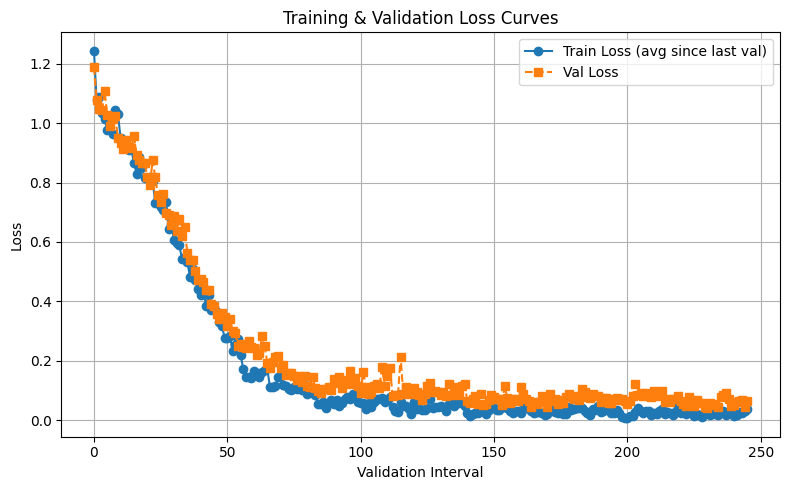

In [7]:
# ================================================================
# Plot Training & Validation Losses (interval-aligned)
# ================================================================
plt.figure(figsize=(8,5))
plt.plot(train_interval_losses, label="Train Loss (avg since last val)", marker='o')
plt.plot(val_losses, label="Val Loss", linestyle="--", marker='s')
plt.xlabel("Validation Interval")
plt.ylabel("Loss")
plt.title("Training & Validation Loss Curves")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [8]:
# ================================================================
# Save Model Checkpoint
# ================================================================
MODEL_PATH = "convlstm_classifier.pth"
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'epoch': epoch,
    'train_losses': train_losses,
    'val_losses': val_losses
}, MODEL_PATH)

print(f"✅ Model saved to {MODEL_PATH}")

✅ Model saved to convlstm_classifier.pth


# INFERENCE

In [9]:
# ================================================================
# Load Model for Inference
# ================================================================
MODEL_PATH = "convlstm_classifier.pth"

model = ConvLSTMClassifier().to(device)

checkpoint = torch.load(MODEL_PATH, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

print("✅ Model loaded and ready for inference.")

✅ Model loaded and ready for inference.


Testing: 100%|████████████████████████████████| 313/313 [03:07<00:00,  1.67it/s]


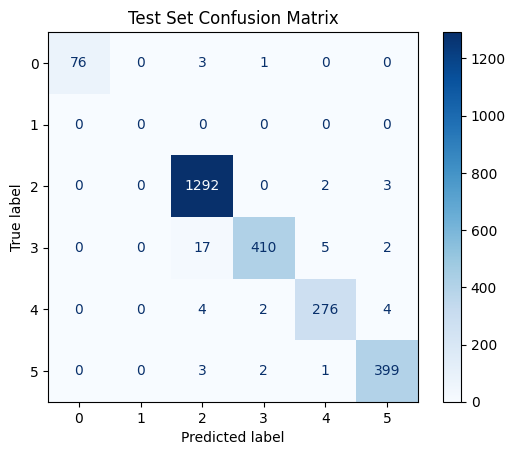


Per-Class Accuracy:
Typhoon Grade 0: 95.00% (76/80 correct)
Typhoon Grade 1: nan% (0/0 correct)
Typhoon Grade 2: 99.61% (1292/1297 correct)
Typhoon Grade 3: 94.47% (410/434 correct)
Typhoon Grade 4: 96.50% (276/286 correct)
Typhoon Grade 5: 98.52% (399/405 correct)
Overall Accuracy: 98.04%


/tmp/ipykernel_1299707/687212286.py:33: RuntimeWarning: invalid value encountered in divide
  per_class_acc = cm.diagonal() / cm.sum(axis=1)


In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# ================================================================
# Evaluate on Test Set
# ================================================================
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for xb, yb in tqdm(test_dl, desc="Testing"):
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        pred_labels = preds.argmax(1).cpu().numpy()
        y_pred.extend(pred_labels)
        y_true.extend(yb.cpu().numpy())

# ------------------------------------------------
# Confusion Matrix
# ------------------------------------------------
num_classes = 6
cm = confusion_matrix(y_true, y_pred, labels=range(num_classes))
disp = ConfusionMatrixDisplay(cm, display_labels=range(num_classes))
disp.plot(cmap="Blues", values_format="d")
plt.title("Test Set Confusion Matrix")
plt.show()

# ------------------------------------------------
# Per-Class Accuracy
# ------------------------------------------------
per_class_acc = cm.diagonal() / cm.sum(axis=1)
print("\nPer-Class Accuracy:")
print("=" * 40)
for i, acc in enumerate(per_class_acc):
    print(f"Typhoon Grade {i}: {acc * 100:.2f}% ({cm.diagonal()[i]}/{cm.sum(axis=1)[i]} correct)")
print("=" * 40)

overall_acc = np.sum(cm.diagonal()) / np.sum(cm)
print(f"Overall Accuracy: {overall_acc * 100:.2f}%")

Generating predictions for visualization...


Visualizing Samples: 100%|█████████████████████| 25/25 [00:00<00:00, 169.83it/s]


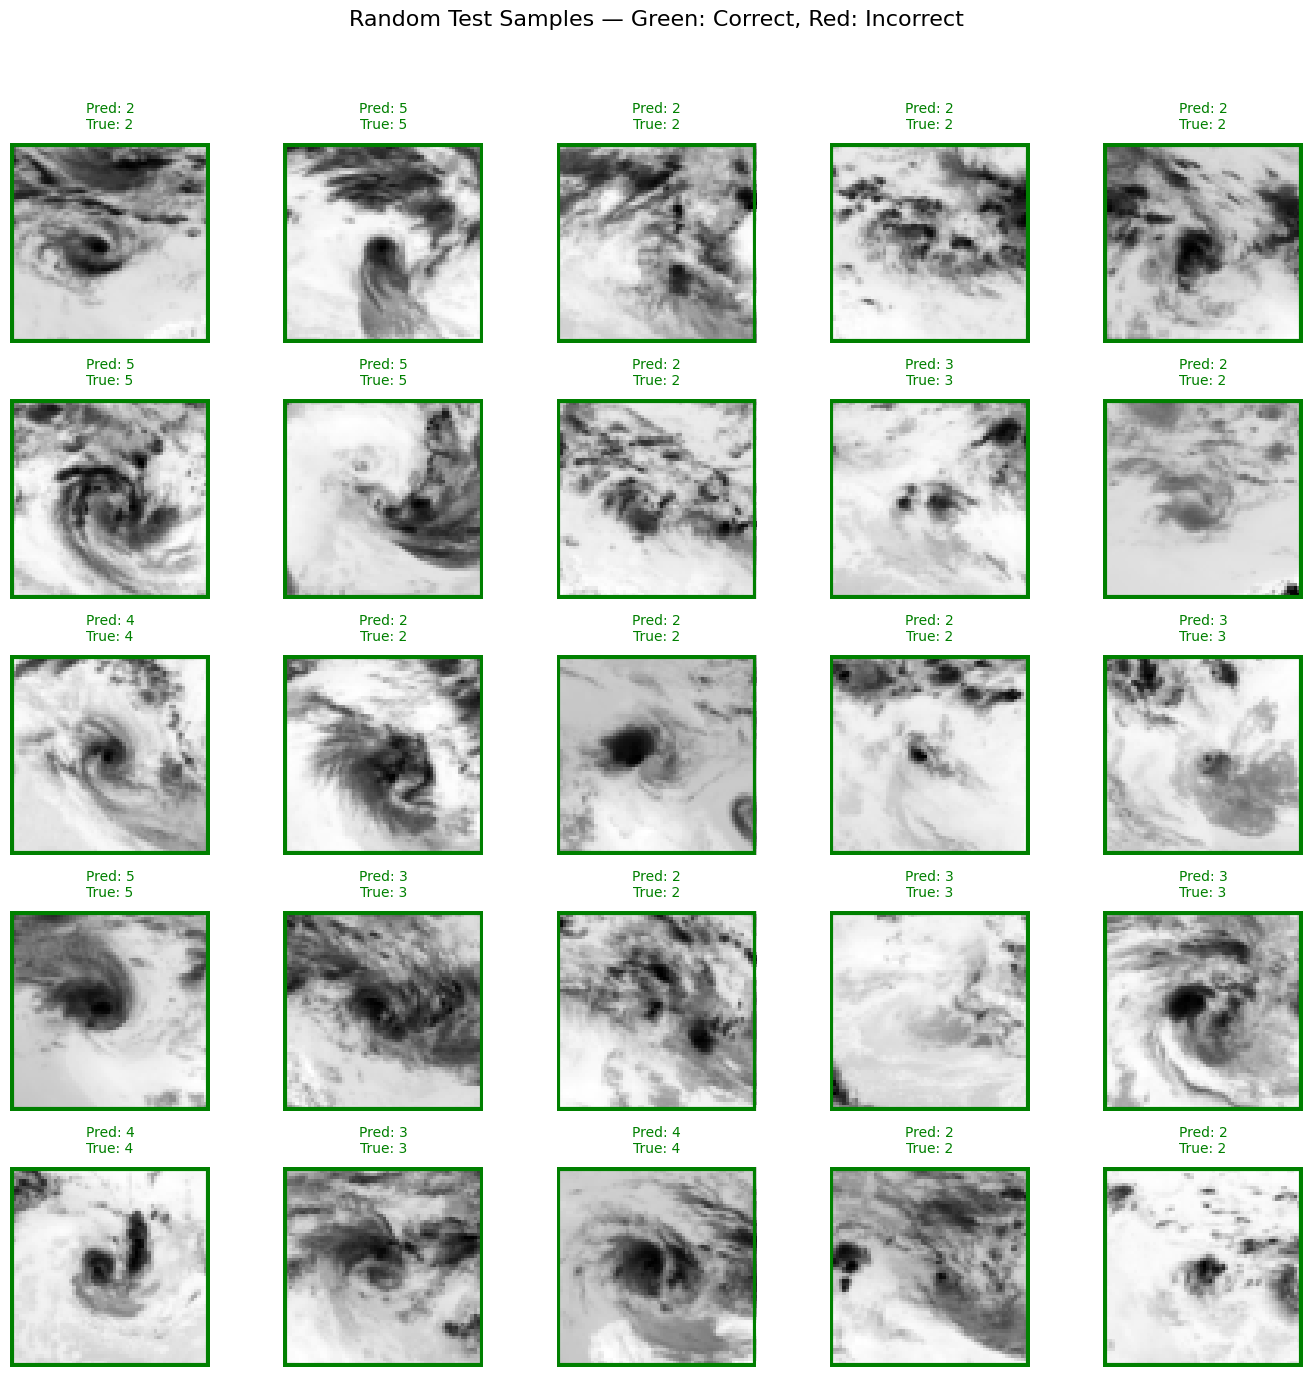

In [11]:
import random
import matplotlib.patches as patches
from tqdm import tqdm

# ================================================================
# Visualize Random Test Predictions (5x5 Grid)
# ================================================================
model.eval()

sample_images = []
sample_preds = []
sample_labels = []

test_samples = list(test_dl)
indices = random.sample(range(len(test_samples)), 25)

print("Generating predictions for visualization...")
with torch.no_grad():
    for i in tqdm(indices, desc="Visualizing Samples"):
        xb, yb = test_samples[i]
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        pred = preds.argmax(1).cpu().numpy()
        label = yb.cpu().numpy()
        sample_images.append(xb.cpu())
        sample_preds.append(pred)
        sample_labels.append(label)

# ------------------------------------------------
# Plot 25 random predictions in 5x5 grid
# ------------------------------------------------
fig, axes = plt.subplots(5, 5, figsize=(14, 14))
axes = axes.flatten()

for idx, ax in enumerate(axes):
    if idx >= len(sample_images):
        ax.axis('off')
        continue

    img_seq = sample_images[idx]             # shape [batch, seq_len, 1, H, W]
    first_frame = img_seq[0, 0, 0].numpy()   # first sample, first timestep, grayscale

    pred_label = sample_preds[idx][0]
    true_label = sample_labels[idx][0]
    correct = pred_label == true_label
    color = "green" if correct else "red"

    ax.imshow(first_frame, cmap="gray")
    ax.set_title(
        f"Pred: {pred_label}\nTrue: {true_label}",
        fontsize=10, color=color, pad=10
    )
    ax.axis("off")

    rect = patches.Rectangle(
        (0, 0),
        first_frame.shape[1] - 1,
        first_frame.shape[0] - 1,
        linewidth=3,
        edgecolor=color,
        facecolor="none"
    )
    ax.add_patch(rect)

plt.subplots_adjust(wspace=0.4, hspace=0.6)
plt.suptitle("Random Test Samples — Green: Correct, Red: Incorrect", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()